In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import talib

pd.options.display.float_format='{:.2f}'.format

df = pd.read_csv('../../data/000905', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)

C:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in greater_equal
C:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in less_equal


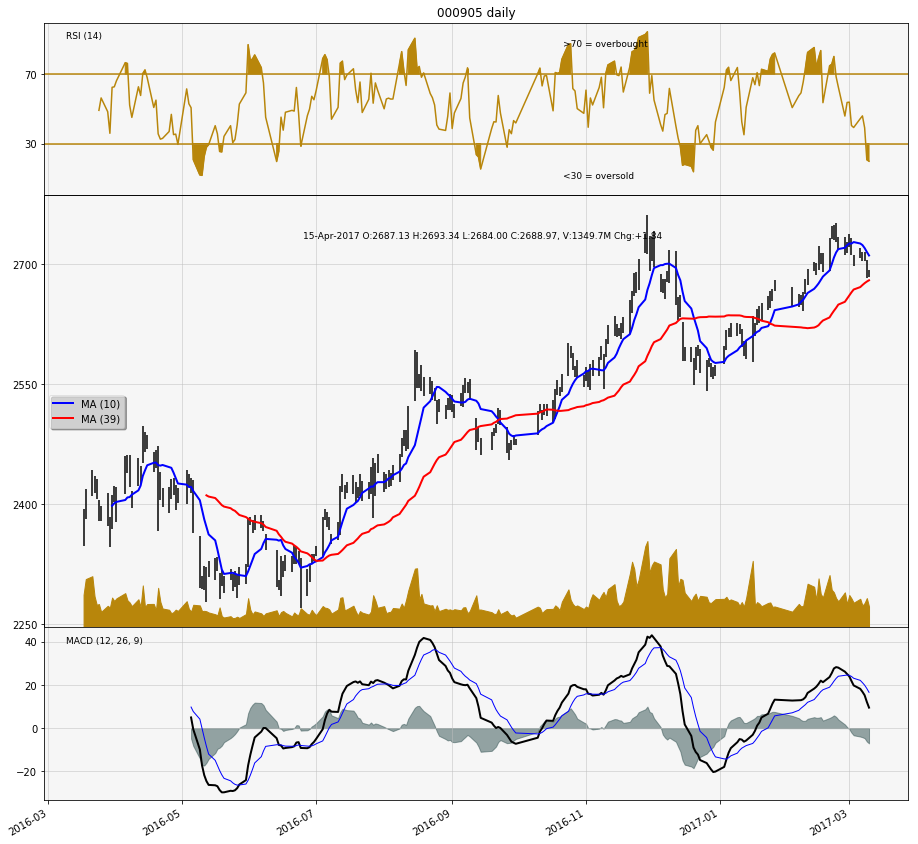

In [34]:
df = df[-240:]
ticker = '000905'
today = enddate = datetime.date.today()

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 9
left, width = 0.1, 2
rect1 = [left, 2.2, width, 0.6]
rect2 = [left, 0.7, width, 1.5]
rect3 = [left, 0.1, width, 0.6]

fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color

ax1 = fig.add_axes(rect1, facecolor=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, facecolor=axescolor, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, facecolor=axescolor, sharex=ax1)

prices = df['Close']
rsi = talib.RSI(np.array(prices), timeperiod=5)
fillcolor = 'darkgoldenrod'

ax1.plot(df.index, rsi, color=fillcolor)
ax1.axhline(70, color=fillcolor)
ax1.axhline(30, color=fillcolor)
ax1.fill_between(df.index, rsi, 70, where=(rsi >= 70), facecolor=fillcolor, edgecolor=fillcolor)
ax1.fill_between(df.index, rsi, 30, where=(rsi <= 30), facecolor=fillcolor, edgecolor=fillcolor)
ax1.text(0.6, 0.9, '>70 = overbought', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.text(0.6, 0.1, '<30 = oversold', transform=ax1.transAxes, fontsize=textsize)
ax1.set_ylim(0, 100)
ax1.set_yticks([30, 70])
ax1.text(0.025, 0.95, 'RSI (14)', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.set_title('%s daily' % ticker)

# plot the price and volume data
dx = 0
low = df['Low']
high = df['High']

deltas = np.zeros_like(prices)
deltas[1:] = np.diff(prices)
up = deltas > 0
ax2.vlines(df.index[up], low[up], high[up], color='black', label='_nolegend_')
ax2.vlines(df.index[~up], low[~up], high[~up], color='black', label='_nolegend_')
ma10 = talib.MA(np.array(prices), timeperiod=10)
ma39 = talib.MA(np.array(prices), timeperiod=39)

linema10, = ax2.plot(df.index, ma10, color='blue', lw=2, label='MA (10)')
linema39, = ax2.plot(df.index, ma39, color='red', lw=2, label='MA (39)')


last = df.ix[-1]
s = '%s O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f' % (
    today.strftime('%d-%b-%Y'),
    last['Open'], last['High'],
    last['Low'], last['Close'],
    last['Volume']*1e-6,
    last['Close'] - last['Open'])
t4 = ax2.text(0.3, 0.9, s, transform=ax2.transAxes, fontsize=textsize)

props = font_manager.FontProperties(size=10)
leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
leg.get_frame().set_alpha(0.5)


volume = df['Money']/1e6  # dollar volume in millions
vmax = volume.max()
poly = ax2t.fill_between(df.index, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor)
ax2t.set_ylim(0, 5*vmax)
ax2t.set_yticks([])


# compute the MACD indicator
fillcolor = 'darkslategrey'
nslow = 26
nfast = 12
nema = 9
macd, macdsignal, macdhist = talib.MACD(np.array(prices), fastperiod=12, slowperiod=26, signalperiod=9)
#emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
#ema9 = moving_average(macd, nema, type='exponential')
ax3.plot(df.index, macd, color='black', lw=2)
ax3.plot(df.index, macdsignal, color='blue', lw=1)
ax3.fill_between(df.index, macdhist, 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)


ax3.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (nfast, nslow, nema), va='top',
         transform=ax3.transAxes, fontsize=textsize)

#ax3.set_yticks([])
# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax1, ax2, ax2t, ax3:
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
#ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
#ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()